### Simulation

In [68]:
import torch
import torch
import torch.optim as optim
import numpy as np
from pathlib import Path
from bmc.fid.engine import BMCSim
from bmc.optimize.optimizer import DifferentiableBMCSimWrapper  # falls du den Wrapper in optimizer.py oder einem Modul hast
from bmc.bmc_tool import prep_rf_simulation
from bmc.set_params import load_params
from bmc.utils.global_device import GLOBAL_DEVICE
import matplotlib.pyplot as plt
import torch.optim as optim
from IPython.display import display, clear_output

from bmc.utils.eval import calculate_flip_angle

In [69]:
# def loss_function(end_signal, pulse_params, lambda_smooth=1e-3):

#     primary_loss = -(end_signal[0]-end_signal[1])
#     # smoothness_loss = torch.mean(torch.abs(pulse_params[:, 1:] - pulse_params[:, :-1]))
#     smoothness_loss = torch.mean(torch.abs(pulse_params[1:] - pulse_params[:-1]))
#     total_loss = primary_loss + lambda_smooth * smoothness_loss
    
#     return total_loss

In [70]:
# seq_file = '/home/danielmiksch/optim/seq_lib/10_ETM.seq'
# config_file = '/home/danielmiksch/optim/sim_lib/config_1pool.yaml'
seq_file = '/Users/danielmiksch/JupyterLab/optim/seq_lib/10_ETM_test.seq'
config_file = '/Users/danielmiksch/JupyterLab/optim/sim_lib/config_1pool.yaml'
seq_file = Path(seq_file).resolve()
config_file = Path(config_file).resolve()

if not Path(config_file).exists():
    raise FileNotFoundError(f"File {config_file} not found.")

if not Path(seq_file).exists():
    raise FileNotFoundError(f"File {seq_file} not found.")

sim_params = load_params(config_file)

low = -20e-6
high = 20e-6
n_iso = 10
z_pos = np.linspace(low, high, n_iso)
z_pos = torch.tensor(z_pos)
z_pos = torch.cat((z_pos, torch.tensor([0.0]))) 

sim_engine_instance = BMCSim(adc_time=5e-3,
                                params=sim_params,
                                seq_file=seq_file,
                                z_positions=z_pos,
                                n_backlog=0,
                                verbose=True,
                                webhook=False)
diff_sim = DifferentiableBMCSimWrapper(sim_engine_instance)

# rf_parameters_list = []
# for i, block_event in enumerate(diff_sim.sim_engine.seq.block_events, start=1):
#         block = diff_sim.sim_engine.seq.get_block(block_event)
#         if block.rf is not None:
#             amp_, ph_, _, _ = prep_rf_simulation(block, diff_sim.sim_engine.params.options["max_pulse_samples"])
#             block_params = torch.stack([amp_, ph_]) #[rf_amp, rf_phase, rf_freq, delay_after_pulse]
#             rf_parameters_list.append(block_params)
# if rf_parameters_list:
#     rf_parameters_tensor = torch.stack(rf_parameters_list)
#     rf_parameters_tensor.requires_grad_(True)
# else:
#     print("No RF blocks found.")

rf_parameters_list = []
for i, block_event in enumerate(diff_sim.sim_engine.seq.block_events, start=1):
    block = diff_sim.sim_engine.seq.get_block(block_event)
    if block.rf is not None:
        amp_, ph_, dtp_, _ = prep_rf_simulation(block, diff_sim.sim_engine.params.options["max_pulse_samples"])
        rf_parameters_list.append(amp_)
if rf_parameters_list:
    rf_parameters_tensor = torch.stack(rf_parameters_list)  # Shape: (N, T)
    rf_parameters_tensor.requires_grad_(True)
else:
    print("No RF blocks found.")

In [71]:
def fourier_loss_all(pulse_params, sample_spacing, sim_engine_instance, f_low, f_high):
    """
    pulse_params: Tensor der Form (N, T) - N Pulse mit T Zeitpunkten.
    sample_spacing: Abtastperiode (d) in Sekunden.
    f_low, f_high: Unerwünschte Frequenzgrenzen.
    """
    fft_signal = torch.fft.fft(pulse_params, dim=-1, norm="backward")  # shape: (N, T)
    fft_magnitude = torch.abs(fft_signal)
    
    freqs = torch.fft.fftfreq(pulse_params.shape[-1], d=sample_spacing) / (sim_engine_instance.params.scanner["b0"] * sim_engine_instance.params.scanner["gamma"]) # shape: (T,)

    penalty_mask = ((freqs < f_low) | (freqs > f_high)).to(pulse_params.dtype)  # shape: (T,)
    penalty_mask = penalty_mask.unsqueeze(0)

    penalty_per_pulse = torch.sum((fft_magnitude ** 2) * penalty_mask, dim=-1)  # shape: (N,)
    
    total_fourier_penalty = torch.mean(penalty_per_pulse)
    
    return total_fourier_penalty


def loss_function(end_signal, pulse_params, 
                  dtp_, sim_engine_instance,
                  lambda_smooth=0, 
                  lambda_pos=1e-3,
                  lambda_fourier=0,
                  f_low=-6, 
                  f_high=6):
  
    # Primäre Loss-Komponente: Differenz zwischen den beiden Simulationssignalen
    primary_loss = -(end_signal[0] - end_signal[1])
    
    # Glattheitsverlust: Bestraft abrupte Änderungen in den Pulsparametern
    smoothness_loss = torch.mean(torch.abs(pulse_params[1:] - pulse_params[:-1]))
    
    # Strafterm für negative Werte der Parameter
    negative_penalty = torch.sum(torch.relu(-pulse_params))
    fourier_penalty = fourier_loss_all(pulse_params, dtp_, sim_engine_instance, f_low, f_high)
    
    total_loss = primary_loss \
                 + lambda_smooth * smoothness_loss \
                 + lambda_pos * negative_penalty \
                 + lambda_fourier * fourier_penalty

    return total_loss

# def loss_function(end_signal, pulse_params, 
#                   lambda_smooth=1e-3, 
#                   lambda_pos=1e-3):
  
#     primary_loss = -(end_signal[0]-end_signal[1])
#     smoothness_loss = torch.mean(torch.abs(pulse_params[1:] - pulse_params[:-1]))
#     negative_penalty = torch.sum(torch.relu(-pulse_params))

#     total_loss = primary_loss \
#                  + lambda_smooth * smoothness_loss \
#                  + lambda_pos * negative_penalty

#     return total_loss

In [72]:
end_signal = diff_sim(rf_parameters_tensor)
difference = end_signal[0] - end_signal[1]
print(difference.item())
loss = loss_function(end_signal, rf_parameters_tensor, dtp_=dtp_, sim_engine_instance=sim_engine_instance)
loss.backward()

0.00025606690631245705


In [73]:
calculate_flip_angle(rf_parameters_tensor[0].detach(), dtp_, sim_engine_instance)

90.00005785657011

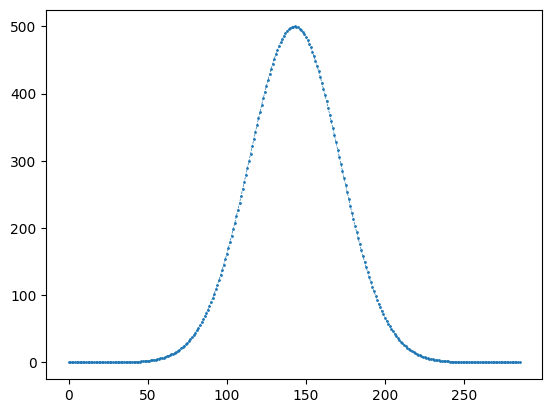

In [74]:
# %matplotlib widget
plt.plot(rf_parameters_tensor[0].detach().numpy(), '--o', markersize=1, linewidth=0.5, label='RF Amplitude') #on Mac OS CPU
# plt.plot(rf_parameters_tensor[0].cpu().detach().numpy(), '--o', markersize=3, label='RF Amplitude') #Cuda
plt.show()

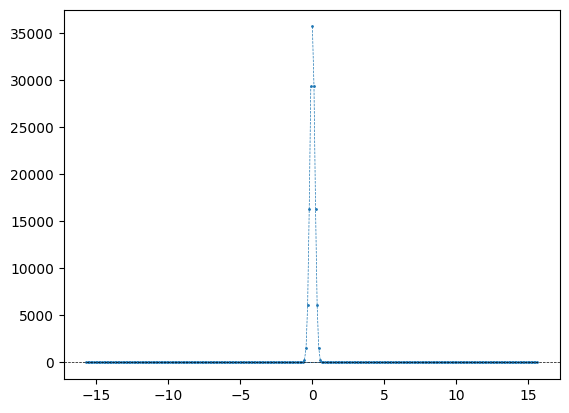

In [75]:
fft_signal = torch.fft.fft(rf_parameters_tensor[0].detach())
freqs = torch.fft.fftfreq(rf_parameters_tensor[0].detach().size(0), d=(dtp_)) / (sim_engine_instance.params.scanner["b0"] * sim_engine_instance.params.scanner["gamma"])
fft_amplitude = torch.abs(fft_signal)
plt.plot(freqs, fft_amplitude, '--o', markersize=1, linewidth=0.5, label='RF Amplitude')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.show()

In [76]:
# optimizer = optim.Adam([rf_parameters_tensor], lr=.1)
# num_epochs = 50

# for epoch in range(num_epochs):
#     sim_engine_instance = BMCSim(adc_time=5e-3,
#                                 params=sim_params,
#                                 seq_file=seq_file,
#                                 z_positions=z_pos,
#                                 n_backlog=0,
#                                 verbose=True,
#                                 webhook=False)
#     diff_sim = DifferentiableBMCSimWrapper(sim_engine_instance)
#     optimizer.zero_grad()
#     end_signal = diff_sim(rf_parameters_tensor)
#     loss = loss_function(end_signal, rf_parameters_tensor)
#     loss.backward()
#     optimizer.step()
#     print(f"Epoch {epoch}: Loss = {loss.item()}, Endsignal = {end_signal.item()}")

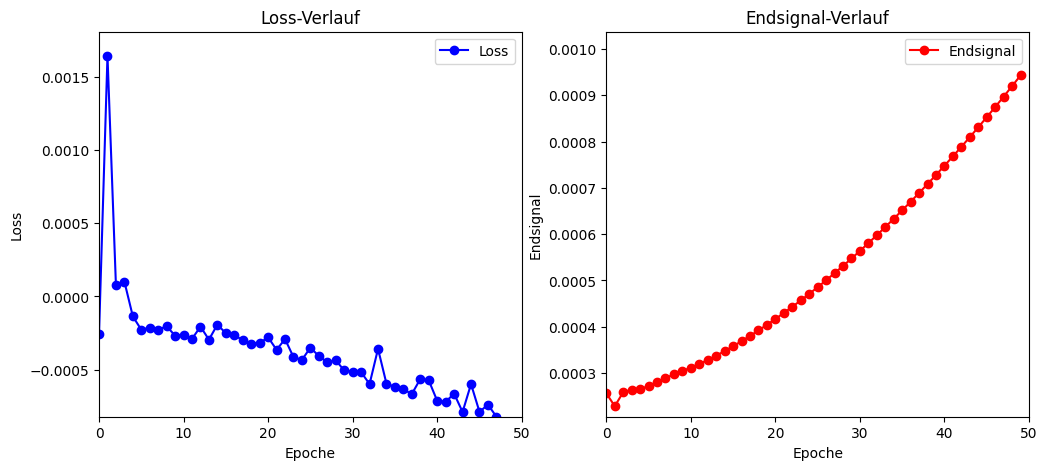

Epoch 49: Loss = -0.0008907955048747697, Endsignal = 0.0009431637927201327


In [77]:
# %matplotlib widget

num_epochs = 50

loss_values = []
signal_values = []
epochs = []

fig, (ax_loss, ax_signal) = plt.subplots(1, 2, figsize=(12, 5))
line_loss, = ax_loss.plot([], [], 'b-o', label='Loss')
ax_loss.set_xlabel('Epoche')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Loss-Verlauf')
ax_loss.legend()
line_signal, = ax_signal.plot([], [], 'r-o', label='Endsignal')
ax_signal.set_xlabel('Epoche')
ax_signal.set_ylabel('Endsignal')
ax_signal.set_title('Endsignal-Verlauf')
ax_signal.legend()

ax_loss.set_xlim(0, num_epochs)
ax_signal.set_xlim(0, num_epochs)


fig.canvas.draw()

def update_plots():
    line_loss.set_data(epochs, loss_values)
    line_signal.set_data(epochs, signal_values)
    
    ax_loss.relim()
    ax_loss.autoscale_view(scalex=False, scaley=True)
    ax_signal.relim()
    ax_signal.autoscale_view(scalex=False, scaley=True)
    
    if loss_values:
        y_min = min(loss_values) * 0.9
        y_max = max(loss_values) * 1.1
        ax_loss.set_ylim(y_min, y_max)
    if signal_values:
        y_min = min(signal_values) * 0.9
        y_max = max(signal_values) * 1.1
        ax_signal.set_ylim(y_min, y_max)
    
    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.pause(0.001)


optimizer = optim.Adam([rf_parameters_tensor], lr=0.1)

for epoch in range(num_epochs):
    sim_engine_instance = BMCSim(adc_time=5e-3,
                                params=sim_params,
                                seq_file=seq_file,
                                z_positions=z_pos,
                                n_backlog=0,
                                verbose=True,
                                webhook=False)
    diff_sim = DifferentiableBMCSimWrapper(sim_engine_instance)
    optimizer.zero_grad()
    end_signal = diff_sim(rf_parameters_tensor)
    # loss = loss_function(end_signal, rf_parameters_tensor)
    loss = loss_function(end_signal, rf_parameters_tensor, dtp_=dtp_, sim_engine_instance=sim_engine_instance)
    loss.backward()
    optimizer.step()
    
    difference = (end_signal[0] - end_signal[1])
    loss_values.append(loss.item())
    signal_values.append(difference.item())
    epochs.append(epoch)
    
    update_plots()

    clear_output(wait=True)
    display(fig)
    print(f"Epoch {epoch}: Loss = {loss.item()}, Endsignal = {difference.item()}")

plt.ioff()

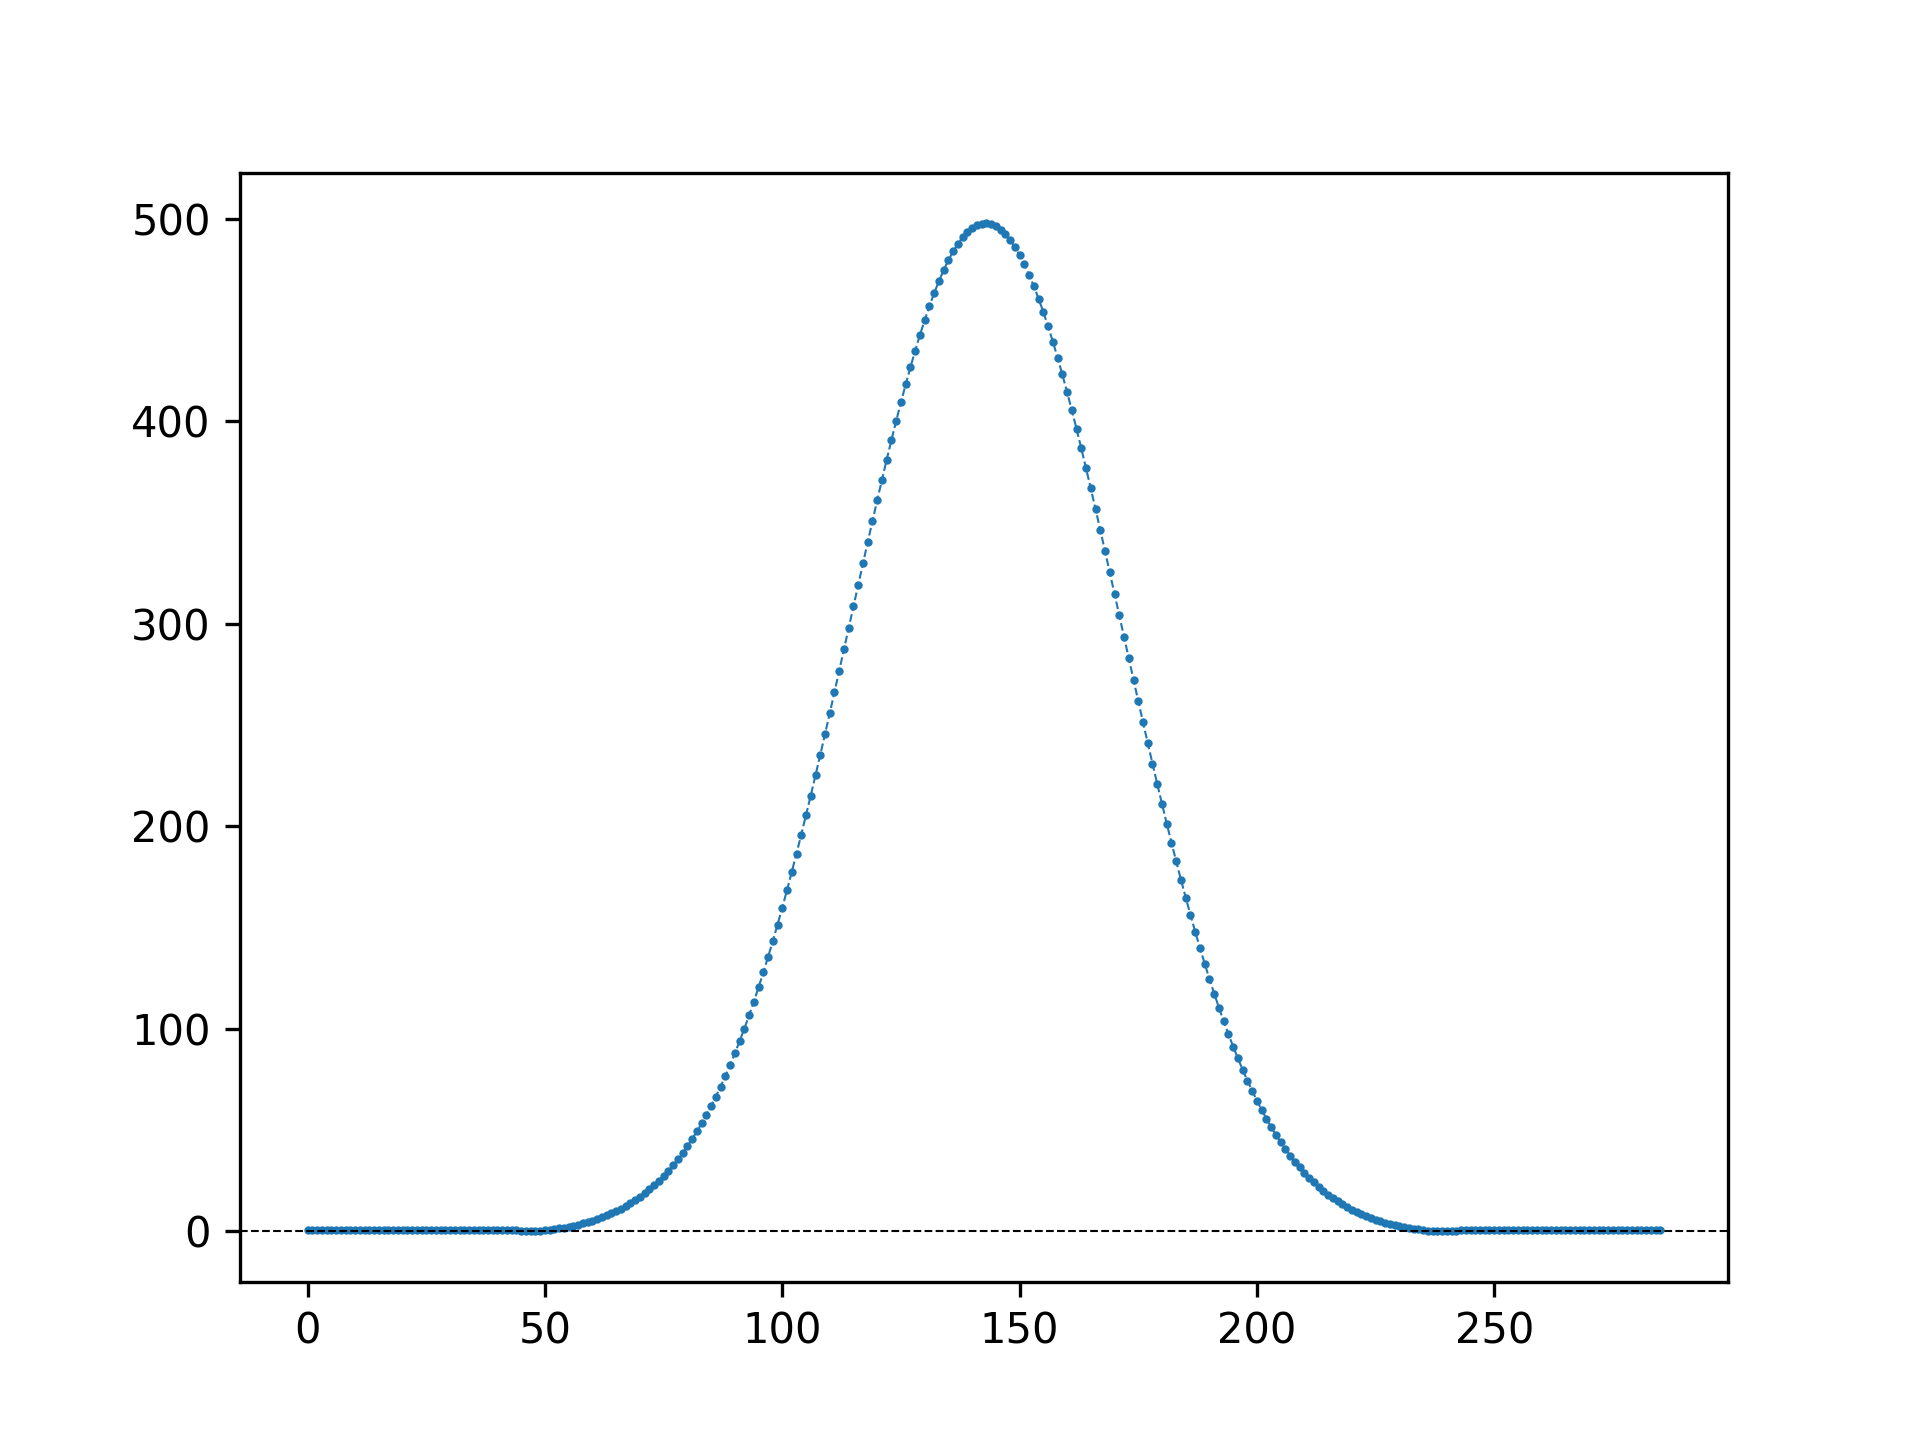

In [83]:
%matplotlib widget
fig, ax = plt.subplots(dpi=300)

plt.plot(rf_parameters_tensor[2].detach().numpy(), '--o', markersize=1, linewidth=0.5, label='RF Amplitude')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.show()

In [79]:
# np.save('pulse_optim.npy', rf_parameters_tensor[0].detach().numpy())

In [89]:
calculate_flip_angle(rf_parameters_tensor[0].detach(), dtp_, sim_engine_instance)
dtp_

7.000000000000001e-06

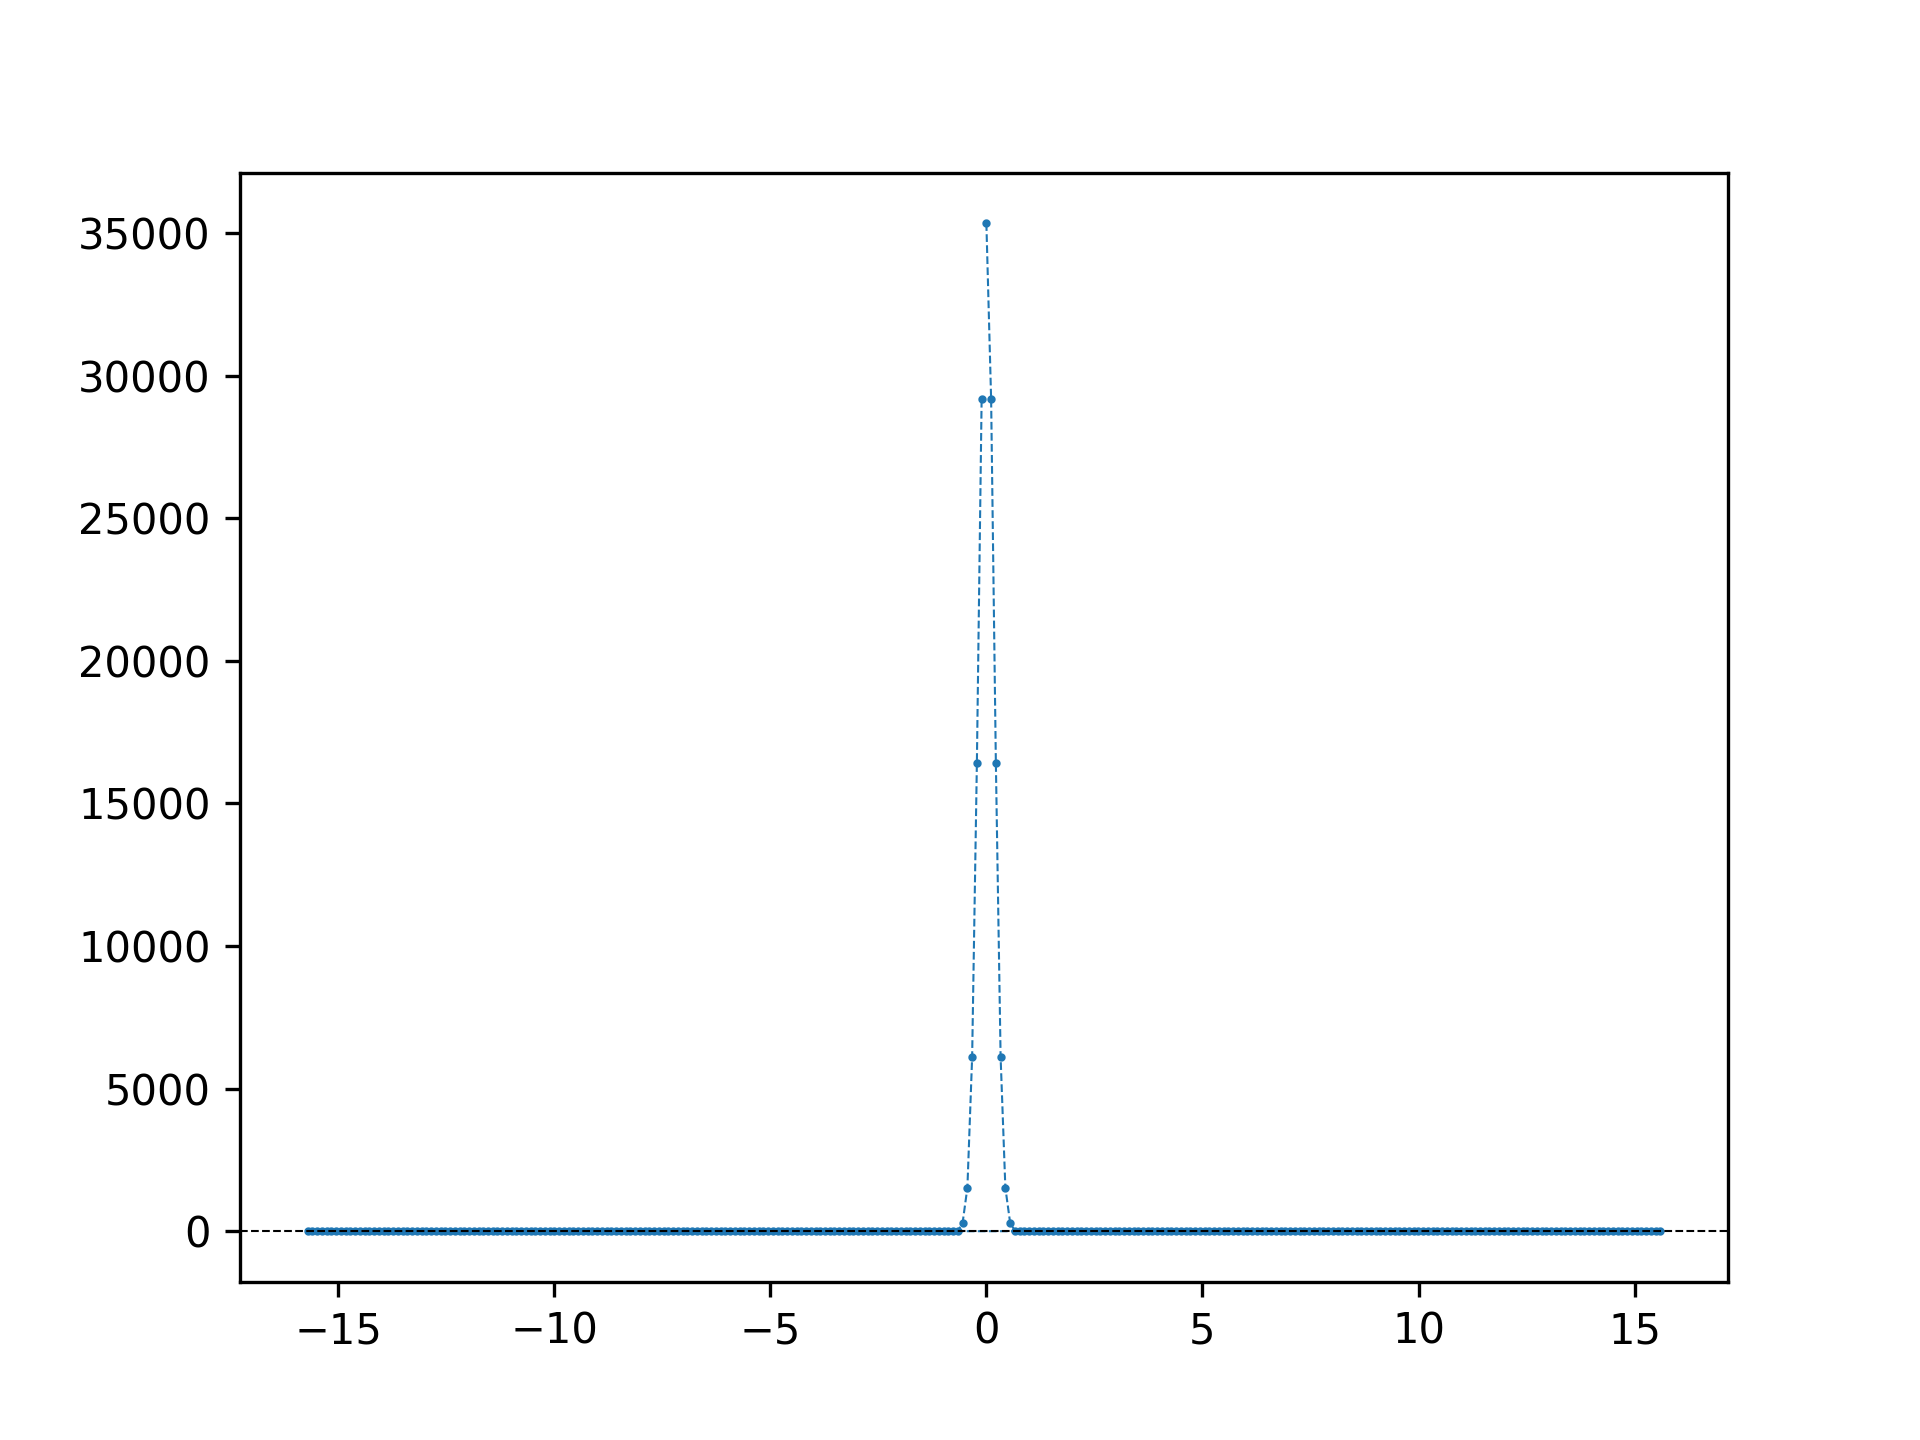

In [85]:
# %matplotlib widget
fig, ax = plt.subplots(dpi=300)

fft_signal = torch.fft.fft(rf_parameters_tensor[2].detach())
freqs = torch.fft.fftfreq(rf_parameters_tensor[2].detach().size(0), d=(dtp_)) / (sim_engine_instance.params.scanner["b0"] * sim_engine_instance.params.scanner["gamma"])
fft_amplitude = torch.abs(fft_signal)
plt.plot(freqs, fft_amplitude, '--o', markersize=1, linewidth=0.5, label='RF Amplitude')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.show()

In [88]:
a, b, c = torch.unbind(rf_parameters_tensor, dim=0)

# Konvertiere jeden Tensor in ein NumPy-Array:
a_np = a.detach().cpu().numpy()  # falls x requires_grad hat
b_np = b.detach().cpu().numpy()
c_np = c.detach().cpu().numpy()
np.save("pulse_1.npy", a_np)
np.save("pulse_2.npy", b_np)
np.save("pulse_3.npy", c_np)
